# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [17]:
import os
import random

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import numpy as np
import pandas as pd
import tensorflow as tf
%matplotlib inline

from utils import get_dataset

In [11]:
from object_detection.utils import label_map_util
def get_label_map(label_map_path = 'label_mapt.pbtxt'):
    label_map = label_map_util.load_labelmap(label_map_path)
    cl_inds = label_map_util.get_label_map_dict(label_map)
    categories = dict()
    for key, value in cl_inds.items():
        categories.update({value: key})
    return categories

In [18]:
dataset = get_dataset("data/waymo/training_and_validation/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['data/waymo/training_and_validation/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['data/waymo/training_and_validation/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 97


In [19]:
# import label map as dictionary
category_ind = get_label_map(label_map_path = './label_map.pbtxt')
print("Object index: {}".format(category_ind))

Object index: {1: 'vehicle', 2: 'pedestrian', 4: 'cyclist'}


In [20]:
# define colormap
class_color_ind = {1: '#FF0000', 2: '#0000FF', 4: '#00FF00'}

In [21]:
# explore specification of each frame
dataset.element_spec

{'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 'source_id': TensorSpec(shape=(), dtype=tf.string, name=None),
 'key': TensorSpec(shape=(), dtype=tf.string, name=None),
 'filename': TensorSpec(shape=(), dtype=tf.string, name=None),
 'groundtruth_image_confidences': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'groundtruth_verified_neg_classes': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'groundtruth_not_exhaustive_classes': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'groundtruth_boxes': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None),
 'groundtruth_area': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'groundtruth_is_crowd': TensorSpec(shape=(None,), dtype=tf.bool, name=None),
 'groundtruth_difficult': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'groundtruth_group_of': TensorSpec(shape=(None,), dtype=tf.bool, name=None),
 'groundtruth_weights': TensorSpec(shape=(None,), dtype=tf.float32, name=Non

In [22]:
# print image dimensions
for instance in dataset.take(1):
    image_h, image_w, color_ch = instance['image'].shape
print("image.shape = ({},{},{})".format(image_h, image_w, color_ch))

image.shape = (640,640,3)


## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [23]:
def display_instances(batch, label_category, label_color, numcols = 1):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    # number of frames in a batch
    batch_size = max([idx for idx,_ in enumerate(batch)]) + 1 
    
    if batch_size % numcols:
        rows = batch_size // numcols + 1
    else:
        rows = batch_size // numcols
        
    fig,ax = plt.subplots(rows, numcols, figsize = (numcols*10, rows*10))
    
    for ind, batch_frame in enumerate(batch):
        image = batch_frame['image'].numpy()
        # get ground truth objejcts
        # format [ymin, xmin, ymax, xmax]
        bboxes = batch_frame['groundtruth_boxes'].numpy()
        # get ground truth classes
        labels = batch_frame['groundtruth_classes'].numpy()
        #resize normalized bounding boxes
        bboxes[:,[0,2]] *= image.shape[0]
        bboxes[:,[1,3]] *= image.shape[1]
    
        # arguments of curr plot
        row_ind = ind//numcols
        col_ind = ind%numcols
        
        ax[row_ind, col_ind].imshow(image)
        ax[row_ind, col_ind].axis('off')
        # display ground truth bounding boxes
        for bbox,label in zip(bboxes,labels):
            # coordinates of bounding box
            y1,x1,y2,x2 = bbox
            # get color mapping
            cl_color = class_color_ind[label]
            # add boxes
            rec = Rectangle((x1, y1), x2-x1, y2-y1, facecolor='none', edgecolor = cl_color)
            ax[row_ind, col_ind].add_patch(rec)
    
    plt.tight_layout()
    plt.show()
    

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

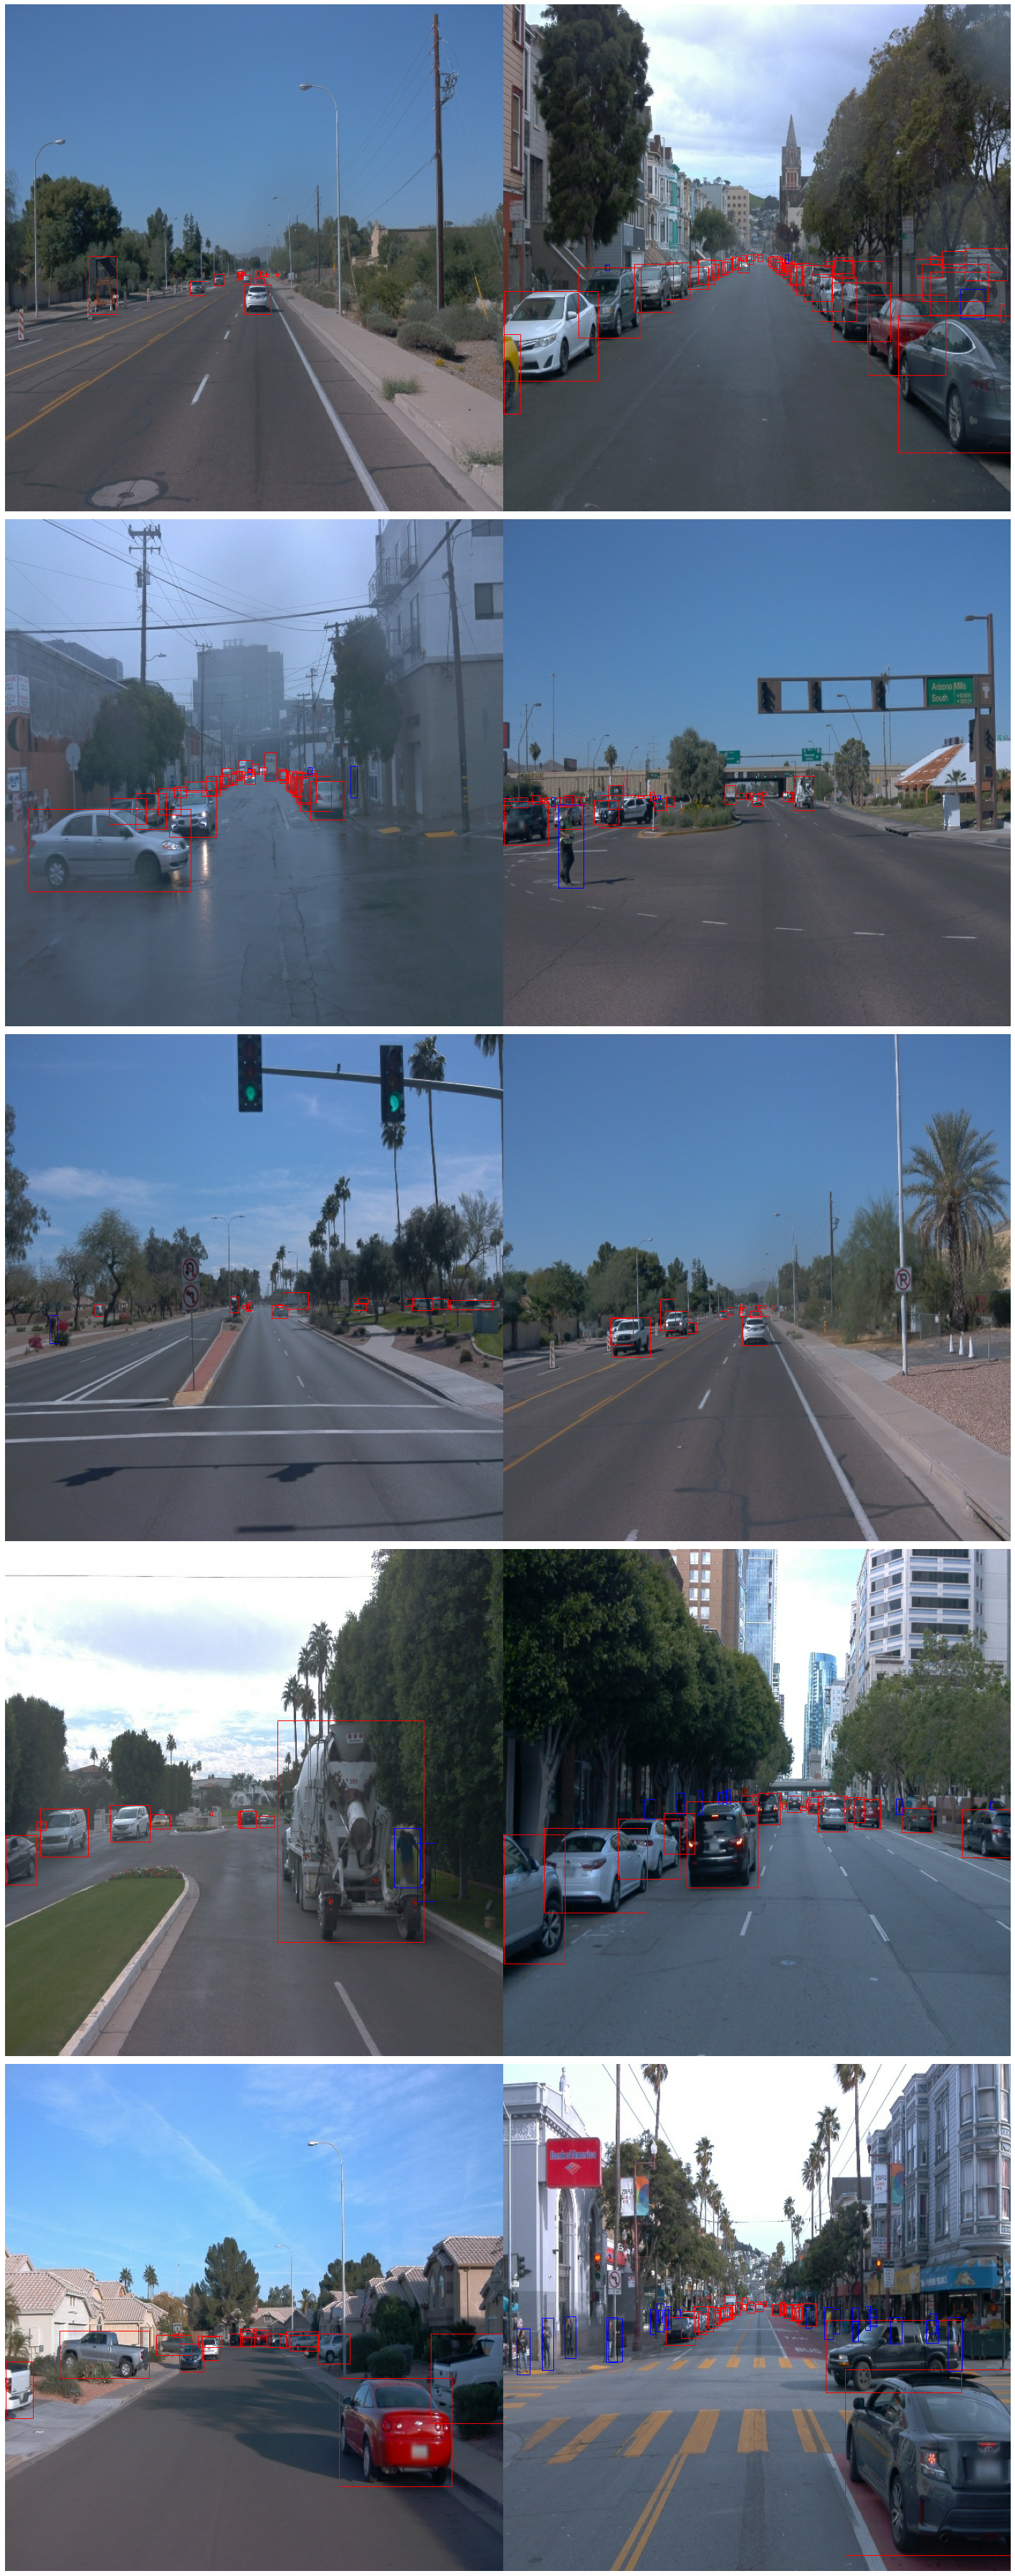

In [24]:
## display 10 random images
batch = dataset.shuffle(100).take(10)
display_instances(batch, category_ind, class_color_ind, 2)

There were images taken at night time with rain drops(resulting in blurred images) impairing the vision (very prevalent). Some snapshots taken at night didn't contain any visually visible vehicles. Headlights created blinding effect which makes it hard to distinguish the object. Occasional fog also introduces issues to object detection. Some objects on the pictures are  really far away which can make it difficult for the ntural network to recognize objects. Some scenes were consideerably more crowded than others. Some snapshots had no objects of interest. Cyclists are the most underrepresented group.

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [28]:
def batch_stats_summary(batch, category_index):
    df_frame_columns = ['objects_counts', 'average_brightness']
    frame_stats = []
    total_obj_counts = {1:0, 2:0, 4:0}
    
    for frame_index, frame in enumerate(batch):
        image = frame['image'].numpy()
        height, width, color_ch = image.shape
        avg_brightness = np.sum(image)/(height*width*color_ch)
        
        gt_bboxes = frame['groundtruth_boxes'].numpy()
        gt_classes = frame['groundtruth_classes'].numpy()
        
        gt_bboxes[:, [0,2]] *= height
        gt_bboxes[:, [1,3]] *= width
        
        frame_obj_counts = {}
        for key in category_index.keys():
            frame_obj_counts[key] = 0
        
        for gt_class,_ in zip(gt_classes, gt_bboxes):
            frame_obj_counts[gt_class] += 1
            total_obj_counts[gt_class] += 1
            
        frame_stats_row = [frame_obj_counts, avg_brightness]
        frame_stats.append(frame_stats_row)
   
    df_frame_stats = pd.DataFrame(frame_stats, columns = df_frame_columns)
    
    return df_frame_stats, total_obj_counts
    

In [77]:
batch_size = 1000
batch = dataset.shuffle(5*batch_size).take(batch_size)

In [78]:
df_frame_stats, obj_batch_counts = batch_stats_summary(batch, category_ind)

In [79]:
df_frame_stats.tail()

objects_counts  average_brightness
995   {1: 24, 2: 5, 4: 0}           75.162752
996   {1: 13, 2: 0, 4: 0}          126.015817
997    {1: 6, 2: 0, 4: 0}           12.494180
998   {1: 11, 2: 0, 4: 0}          120.374115
999  {1: 27, 2: 10, 4: 0}           88.755667

In [80]:
 obj_batch_counts

{1: 17430, 2: 4669, 4: 131}

In [81]:
batch_obj_counts = list(obj_batch_counts.values())
total_objs = sum(obj_batch_counts.values())
obj_percentage_in_batch = [batch_obj_counts[0]/total_objs, 
                               batch_obj_counts[1]/total_objs, 
                               batch_obj_counts[2]/total_objs]


<function matplotlib.pyplot.show(close=None, block=None)>

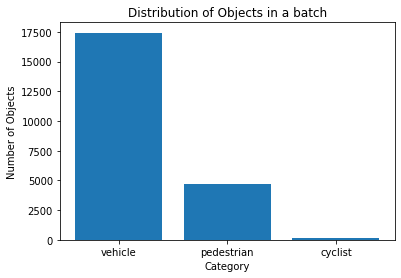

In [82]:
plt.bar(list(category_ind.values()), list(obj_batch_counts.values()))
plt.xlabel("Category")
plt.ylabel("Number of Objects")
plt.title("Distribution of Objects in a batch")
plt.show

Percentage of vehicles = 78.41 %
Percentage of pedstrians = 21.00 %
Percentage of cyclists = 0.59 %


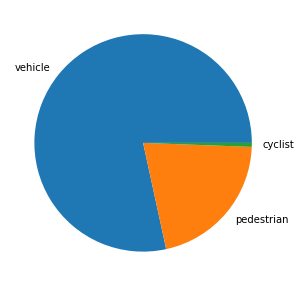

In [84]:
f, ax = plt.subplots(1,1,figsize = (10,5))
ax.pie(batch_obj_counts, labels = list(category_ind.values()))

print("Percentage of vehicles = {:0.2f} %".format(obj_percentage_in_batch[0]*100))
print("Percentage of pedstrians = {:0.2f} %".format(obj_percentage_in_batch[1]*100))
print("Percentage of cyclists = {:0.2f} %".format(obj_percentage_in_batch[2]*100))

Average brightness across all frames: 99.05


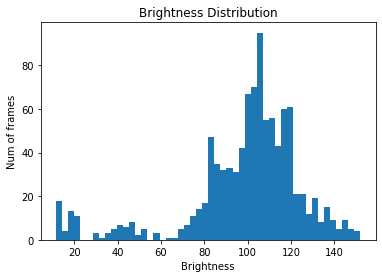

In [85]:
plt.hist(df_frame_stats['average_brightness'],bins = 50)
plt.title('Brightness Distribution')
plt.xlabel('Brightness')
plt.ylabel("Num of frames")

print("Average brightness across all frames: {:.2f}".format(df_frame_stats["average_brightness"].mean()))

70 is night